# Линейный SVM "своими руками"

## Генерируем обучающую и тестовую выборку для экспериментов

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

X, y = datasets.make_classification(
    n_samples=10000, n_features=20, 
    n_classes=2, n_informative=20, 
    n_redundant=0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

print("Количество объектов в тренировочной выборке: {}".format(len(X_train)))
print("Количество объектов в тестовой выборке: {}".format(len(X_test)))
print("Количество признаков: {}".format(X.shape[1]))

Количество объектов в тренировочной выборке: 8000
Количество объектов в тестовой выборке: 2000
Количество признаков: 20


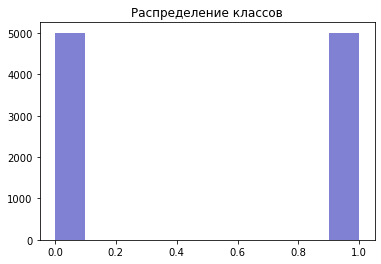

In [52]:
import matplotlib.pyplot as plt

plt.hist(y, alpha=0.5, color='#0504aa')
plt.title('Распределение классов')
plt.show()

## Пишем свой класс для SVM

In [344]:
import numpy as np
from random import randint
import random


np.random.seed(42)
random.seed(42)


class MySVM(object):
    def __init__(self, C=1, r=0.9):
        self.C = C # regularization constant
        self.r = r # parameter from learning_rate (step)
        #self.w = 0 # svm parameters
        #self.w0 = 0

    # f(x) = <w,x> + w_0
    def f(self, x):
        return np.dot(self.w, x) + self.w0

    # a(x) = [f(x) > 0]
    def a(self, x):
        return 1 if self.f(x) > 0 else 0
    
    # predicting answers for X_test
    def predict(self, X_test):
        return np.array([self.a(x) for x in X_test])

    # l2-regularizator
    def reg(self):
        return 1.0 * sum(self.w ** 2) / (2.0 * self.C)

    # l2-regularizator derivative
    def der_reg(self):
        return self.w / self.C

    # hinge loss
    def loss(self, x, answer):
        return max([0, 1 - answer * self.f(x)])

    # hinge loss derivative
    def der_loss(self, x, answer):
        return -1.0 if answer * self.f(x) < 1 else 0.0

    # fitting w and w_0 with SGD
    def fit(self, X_train, y_train):
        loss_history = list()
        
        dim = len(X_train[0])
        self.w = np.random.rand(dim) # initial value for w
        self.w0 = np.random.randn() # initial value for w_0
        
        # 10000 steps is OK for this example
        # another variant is to continue iterations while error is still decreasing
        for k in range(10000):  
            
            # random example choise
            rand_index = randint(0, len(X_train) - 1) # generating random index
            x = X_train[rand_index]
            y = y_train[rand_index]

            # simple heuristic for step size
            step = 0.5 * self.r ** k

            # w update
            self.w -= step * (y * x * self.der_loss(x, y) + self.der_reg())
            
            # w_0 update
            self.w0 -= step * y * self.der_loss(x, y)
            
            loss_history.append(self.loss(x, y) + self.reg())
            
        return loss_history

## Пробуем обучить наш классификатор и посмотреть на качество на тесте

In [496]:
model = MySVM(C=3.836, r=0.99)
loss_history = model.fit(X_train, y_train)
print(model.w, model.w0)

[-0.05474406 -0.10822286  0.04785698  0.36806046 -0.1275915   0.07891241
 -0.13860031  0.03422799 -0.27077552 -0.30694102  0.07298519  0.03580243
  0.33037442  0.03239439 -0.25298393  0.18432852  0.21930816  0.2462006
  0.04211777  0.05298053] -0.19342264612782004


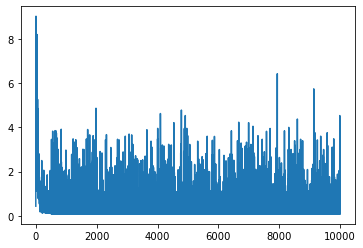

In [497]:
plt.plot(loss_history)

In [498]:
predictions = model.predict(X_test)

In [499]:
print(predictions)

[1 0 1 ... 1 1 1]


In [500]:
print(y_test)
print("Количество объектов тестовой выборки: {}".format(len(y_test)))
print("Количество ответов 1 в тестовой выборке: {}".format(sum(y_test)))

[1 0 1 ... 1 0 1]
Количество объектов тестовой выборки: 2000
Количество ответов 1 в тестовой выборке: 991


In [501]:
print("Количество объектов тестовой выборки: {}".format(len(predictions)))
print("Количество ответов 1 в тестовой выборке: {}".format(sum(predictions)))

Количество объектов тестовой выборки: 2000
Количество ответов 1 в тестовой выборке: 1186


In [502]:
print("Доля верных ответов на тестовой выборке: {}".format(sum(predictions == y_test) / float(len(y_test))))

Доля верных ответов на тестовой выборке: 0.7545


## Задания:

### - Допишите недостающие функции в MySVM (производные и обновление весов)

### - Сравните качество с sklearn LinearSVC

In [504]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [547]:
model = LinearSVC(loss='hinge', C=3, max_iter=10000, random_state=42)
model.fit(X_train, y_train)
print("Доля верных ответов на тестовой выборке: {}".format(accuracy_score(y_test, model.predict(X_test))))

Доля верных ответов на тестовой выборке: 0.7985


In [563]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(LinearSVC(loss='hinge'),
                             param_grid={'C': np.linspace(0.01, 2, 40)},
                             cv=5).fit(X_train, y_train)

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\ростислав\appdata\local\programs\python

In [564]:
grid_searcher.best_params_

{'C': 0.8774358974358974}

In [565]:
accuracy_score(grid_searcher.predict(X_test), y_test)

0.8005

## Resume 
* Наш самодельный SVM классификатор дал accuracy = 0.7545
* LinearSVC accuracy = 0.8005 